In [1]:
import numpy as np
import pandas as pd

In [2]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='solar')

# Creating Synthetic Data

For this lecture we use a simple synthetic dataset to simplify the presentation of ideas.

In [3]:
n = 100
np.random.seed(42)
noise = 0.7
w_true = np.array([1., 3.])
quad = -4

x = np.sort(np.random.rand(n)*2 - 1.)
y = w_true[0] + w_true[1] * x + quad*(x**2) + noise * np.random.randn(n)
x[0] = -1.5
y[0] = 10

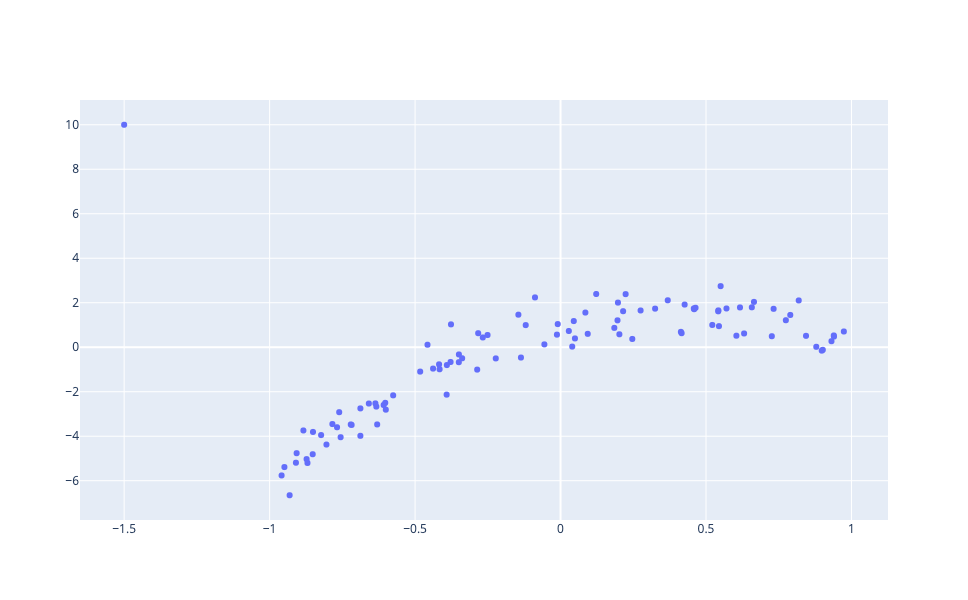

In [4]:
raw_data_plot = go.Scatter(x=x, y=y, name="Raw Data", mode='markers')
fig = go.Figure([raw_data_plot])
fig.update_layout(height=600)

# Defining The Model and Loss Functions

Starting with a simple linear model:

In [5]:
def model(w, x):
    return w[0] + w[1] * x

From the previous lecture we showed how to analytically derive the minimizer for the squared loss:

In [6]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    return np.mean (standard_units(x) * standard_units(y))

def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

def intercept(x, y):
    return np.mean(y) - slope(x, y)*np.mean(x)

Computing the weights based on the functions from prior lecture.

In [7]:
w_mse = np.array([intercept(x,y), slope(x,y)])
w_mse

array([-0.26649881,  2.64187294])

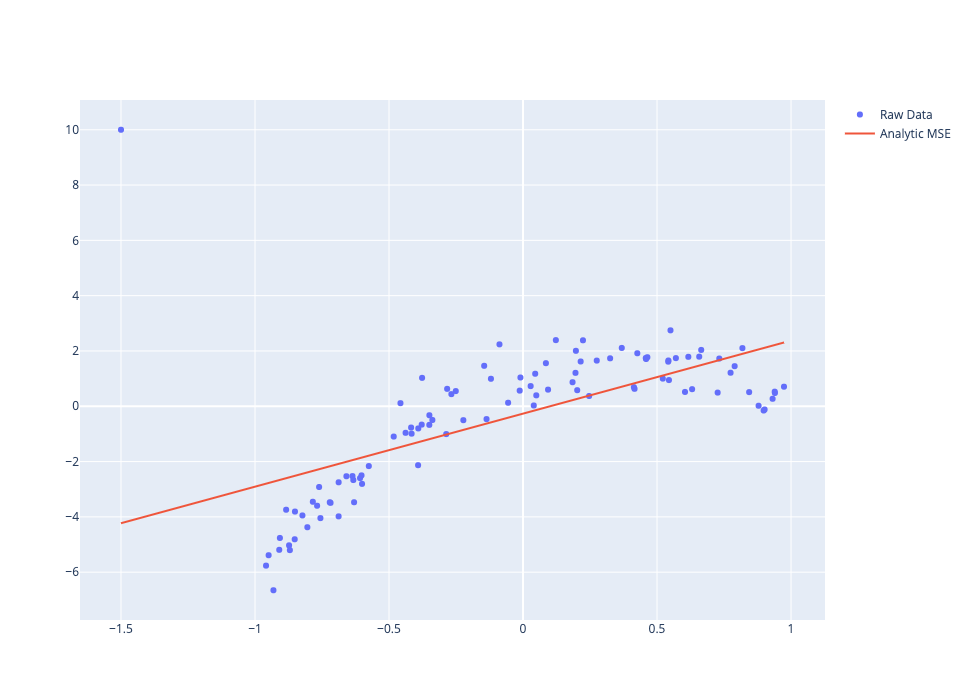

In [8]:
y_hat = model(w_mse, x)
analytic_mse_line = go.Scatter(x=x,y=y_hat, name="Analytic MSE")
fig = go.Figure([raw_data_plot, analytic_mse_line])
fig.update_layout(height=700)
fig

# Visualizing the Residuals

The following code is for Plotly only to generate residual plots.

In [9]:
def residual_lines(x, y, yhat):
    return [ 
        go.Scatter(x=[x,x], y=[y,yhat],
               mode='lines', showlegend=False, 
               line=dict(color='black', width = 0.5))
        for (x, y, yhat) in zip(x, y, y_hat)
    ]

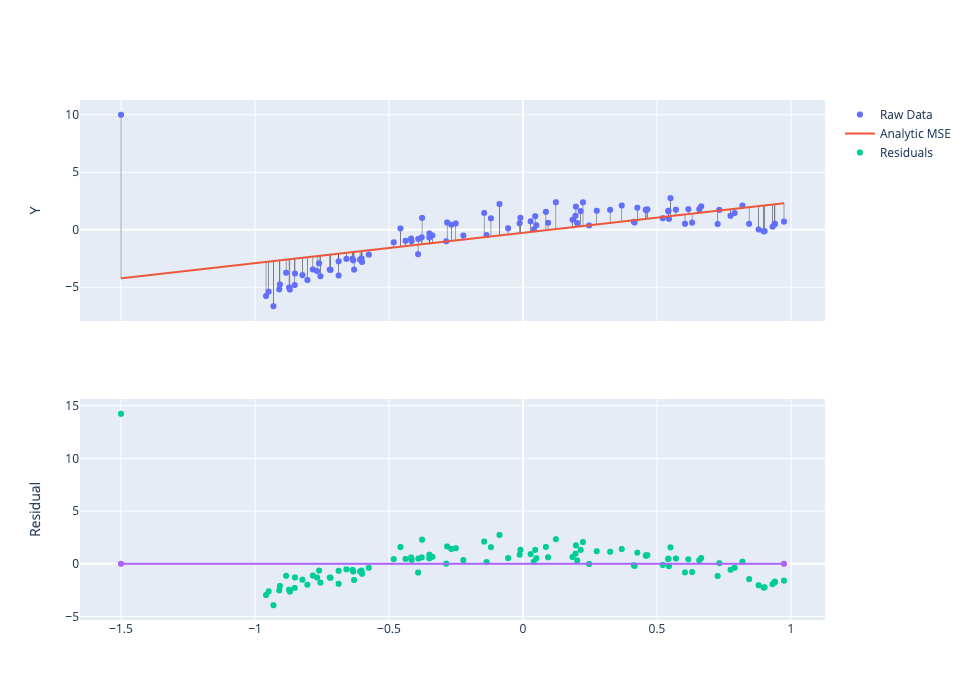

In [10]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
for t in residual_lines(x,y,y_hat) + [raw_data_plot, analytic_mse_line]:
    fig.add_trace(t, row=1,col=1)
fig.add_trace(go.Scatter(x=x, y =   y -y_hat , mode='markers', name='Residuals'), row=2, col=1)
fig.add_trace(go.Scatter(x=[x.min(), x.max()], y = [0,0], showlegend=False), row=2, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.update_layout(height=700)

# Visualizing the Loss Surface

In [11]:
def mse_loss(yhat, y):
    return ((yhat - y)**2).mean()

Exhaustively try a large number of possible parameter values.

In [12]:
# Compute Range of intercpet values
w0values = np.linspace(w_mse[0]-1, w_mse[0]+1, 50) 
# Compute Range of Slope values
w1values = np.linspace(w_mse[1]-1, w_mse[1]+1, 50)
# Construct "outer product of all possible values"
(u,v) = np.meshgrid(w0values, w1values)
# Convert into a tall matrix with each row corresponding to a possible parameterization
ws = np.vstack((u.flatten(),v.flatten())).transpose()
# Compute the Loss for each parameterization
mse_loss_values = np.array([mse_loss(y, model(w, x)) for w in ws]).reshape(u.shape)

Make a really cool looking visualization of the loss surface.

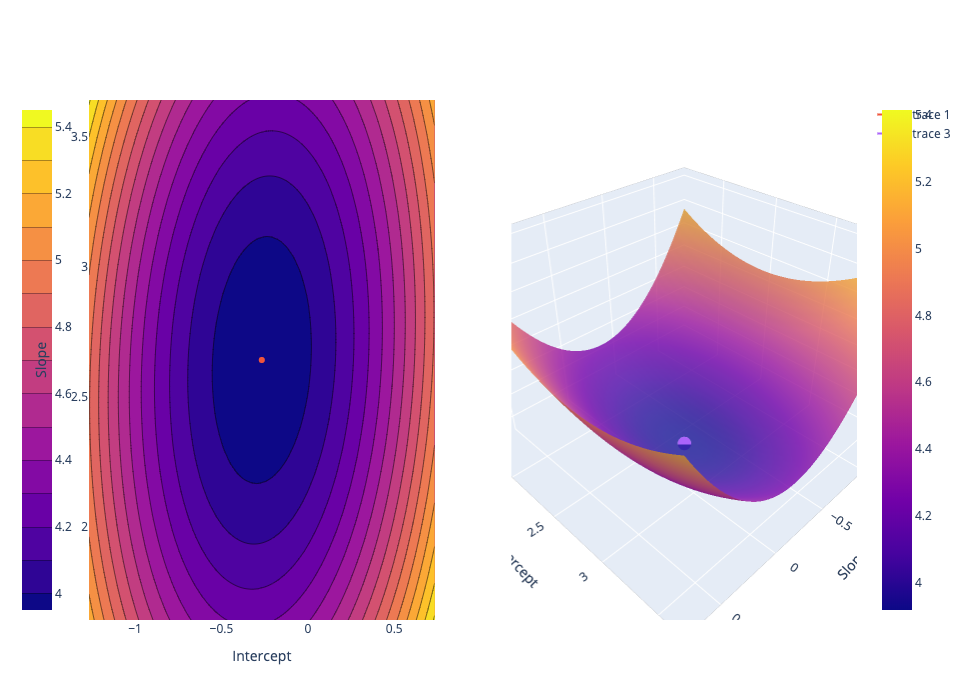

In [13]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'contour'}, {'type': 'surface'}]])
# Make Contour Plot and Point
fig.add_trace(go.Contour(x=w0values, y=w1values, z=mse_loss_values , colorbar=dict(x=-.1)), row=1, col=1)
fig.add_trace(go.Scatter(x=[w_mse[0]], y=[w_mse[1]]), row=1, col=1)
# Make Surface Plot and Point
fig.add_trace(go.Surface(x=w0values, y=w1values, z=mse_loss_values, opacity=0.9), row=1, col=2)
fig.add_trace(go.Scatter3d(x=[w_mse[0]], y=[w_mse[1]], z=[mse_loss(y, model(w_mse,x))]), row=1, col=2)
# Cleanup Legend
fig.update_layout(scene=dict(xaxis=dict(title='Slope'), yaxis=dict(title='Intercept'), zaxis=dict(title="MSE Loss")))
fig.update_xaxes(title_text="Intercept", row=1, col=1)
fig.update_yaxes(title_text="Slope", row=1, col=1)
fig.update_layout(height=700)


# Examining the $L^1$ Loss

We just solved the model for the $L^2$ loss.  We now examine the $L^1$ loss.  We first begin by visualizing the loss surface.

In [14]:
def abs_loss(yhat, y):
    return (np.abs(yhat - y)).mean()

In [15]:
# Compute Range of intercpet values
w0values = np.linspace(w_mse[0]-1, w_mse[0]+1, 50) 
# Compute Range of Slope values
w1values = np.linspace(w_mse[1]-1, w_mse[1]+1, 50)
# Construct "outer product of all possible values"
(u,v) = np.meshgrid(w0values, w1values)
# Convert into a tall matrix with each row corresponding to a possible parameterization
ws = np.vstack((u.flatten(),v.flatten())).transpose()
# Compute the Loss for each parameterization
abs_loss_values = np.array([abs_loss(y, model(w, x)) for w in ws]).reshape(u.shape)

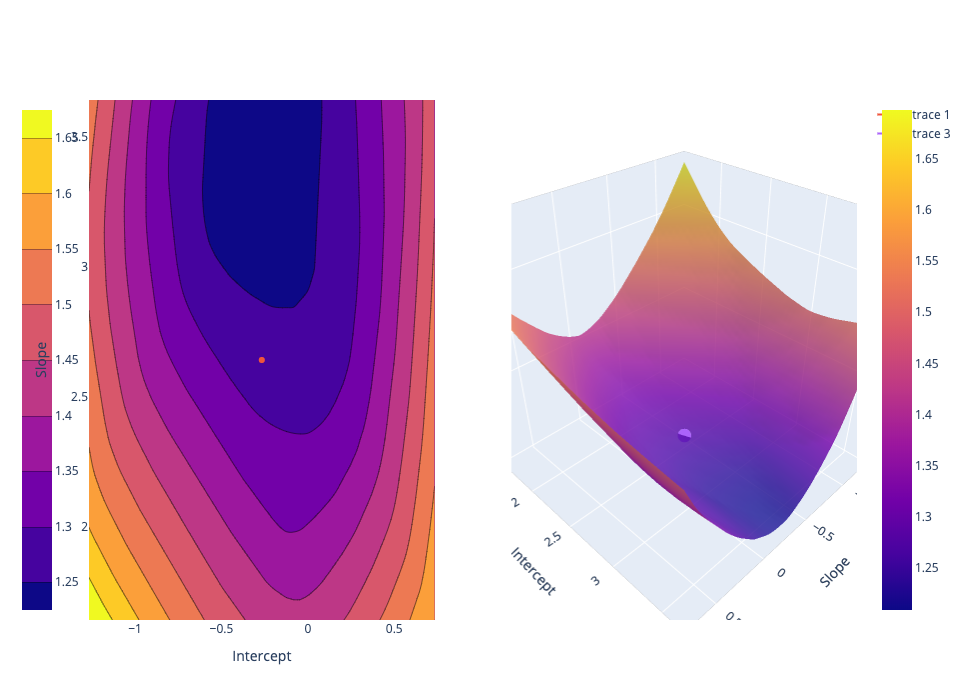

In [16]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'contour'}, {'type': 'surface'}]])
# Make Contour Plot and Point
fig.add_trace(go.Contour(x=w0values, y=w1values, z=abs_loss_values, colorbar=dict(x=-.1)), row=1, col=1)
fig.add_trace(go.Scatter(x=[w_mse[0]], y=[w_mse[1]]), row=1, col=1)
# Make Surface Plot and Point
fig.add_trace(go.Surface(x=w0values, y=w1values, z=abs_loss_values, opacity=0.9), row=1, col=2)
fig.add_trace(go.Scatter3d(x=[w_mse[0]], y=[w_mse[1]], z=[abs_loss(y, model(w_mse,x))]), row=1, col=2)
# Cleanup Legend
fig.update_layout(scene=dict(xaxis=dict(title='Slope'), yaxis=dict(title='Intercept'), zaxis=dict(title="MSE Loss")))
fig.update_xaxes(title_text="Intercept", row=1, col=1)
fig.update_yaxes(title_text="Slope", row=1, col=1)
fig.update_layout(height=700)

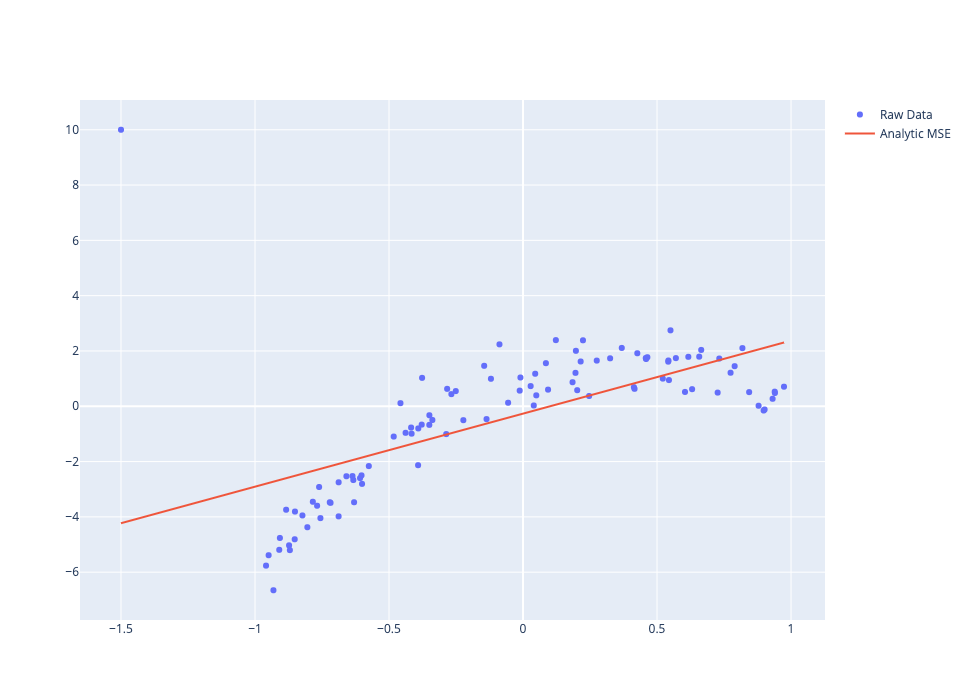

In [17]:
fig = go.Figure([raw_data_plot, analytic_mse_line])
fig.update_layout(height=700)
fig

# Quick Introduction to Algorithmic Differentiation

In this lecture we are going to introduce PyTorch.  PyTorch is sort of like learning how to use Thor's hammer, it is way overkill for basically everything you will do and is probably the wrong solution to most problems you will encounter. However, it also really powerful and will give you the skills needed to take on very challenging problems. 

In [18]:
import torch

Defining a variable $\theta$ with an initial value 1.0

In [19]:
theta = torch.tensor([1.0], requires_grad=True, dtype=torch.float64)
theta

tensor([1.], dtype=torch.float64, requires_grad=True)

Suppose we compute the following value from our tensor `theta`

$$
z = \left(1 - log\left(1 + \exp(\theta) \right) \right)^2
$$

In [20]:
z = (1 - torch.log(1 + torch.exp(theta)))**2
z

tensor([0.0981], dtype=torch.float64, grad_fn=<PowBackward0>)

Notice that every derived value has an attached a gradient function that is used to compute the backwards path.

In [21]:
z.grad_fn

In [22]:
z.grad_fn.next_functions

((<RsubBackward1 at 0x7ffb29d90150>, 0),)

In [23]:
z.grad_fn.next_functions[0][0].next_functions

((<LogBackward at 0x7ffb29d90b10>, 0),)

We can visualize these functions 

In [24]:
# !pip install torchviz
# !brew install graphviz
# from torchviz import make_dot
# make_dot(z)

If you were unable to run the above cell here is what the output looks like:

<img src="torch_graph.png" alt="TorchGraph" style="height:400px;">


These backward functions tell Torch how to compute the gradient via the chain rule.  This is done by invoking backward on the computed value.

In [25]:
z.backward()

In [26]:
theta.grad

tensor([0.4580], dtype=torch.float64)

We can use `item` to extract a single value.

In [27]:
theta.grad.item()

0.4580252880326174

We can compare this witht he hand computed derivative:

\begin{align}
\frac{\partial z}{\partial\theta} &= \frac{\partial}{\partial\theta}\left(1 - \log\left(1 + \exp(\theta)\right)\right)^2 \\
 & = 2\left(1 - \log\left(1 + \exp(\theta)\right)\right)\frac{\partial}{\partial\theta} \left(1 - \log\left(1 + \exp(\theta)\right)\right)\\
 & = 2\left(1 - \log\left(1 + \exp(\theta)\right)\right) (-1) \frac{\partial}{\partial\theta} \log\left(1 + \exp(\theta)\right) \\
 & = 2\left(1 - \log\left(1 + \exp(\theta)\right)\right)   \frac{-1}{1 + \exp(\theta)}\frac{\partial}{\partial\theta}\left(1 + \exp(\theta)\right) \\
 & = 2\left(1 - \log\left(1 + \exp(\theta)\right)\right)   \frac{-1}{1 + \exp(\theta)}\exp(\theta) \\
  & = -2\left(1 - \log\left(1 + \exp(\theta)\right)\right)   \frac{\exp(\theta)}{1 + \exp(\theta)}
\end{align}

In [28]:
def z_derivative(theta):
    return -2 * (1 - np.log(1 + np.exp(theta))) * np.exp(theta) / (1. + np.exp(theta))

In [29]:
z_derivative(1.)

0.45802528803261744

# Minimizing the Absolute Loss Using Gradient Descent

Here we will use pytorch to implement gradient descent.

In [30]:
import torch

Converting numpy data to tensors.  I will call them `tx` and `ty` to reduce confusion.

In [31]:
tx = torch.from_numpy(x)
ty = torch.from_numpy(y)

## Defining a Model 

The following defines a simple linear model as a basic class.  The `init` function initializes the weights of the model.  Here we have two weights, intercept and slope.  The weights are initialized with `requires_grad` set to true so PyTorch will track the gradients of these weights.

The `predict` function makes a prediction based on the input `x` and the weights.  In general, `x` will contain one or more inputs and so the function should work in either case. 

the `__call__` function allows me to call `model.predict(x)` as `model(x)` treating my models as a function. 

In [32]:
class SimpleLinearModel:
    def __init__(self):
        self.w = torch.zeros(2, 1, requires_grad=True)
    
    def predict(self, x):
        w = self.w
        return w[0] + w[1] * x

    def __call__(self, x):
        return self.predict(x)

In [33]:
model = SimpleLinearModel()
model(tx)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>)

## The PyTorch `nn.Module`
The ideal way to define a model in pytorch is to extend the `nn.Module` class and introduce `Parameters`.

In [34]:
from torch import nn

In [35]:
class SimpleLinearModel(nn.Module):
    def __init__(self, w=None):
        super().__init__()
        # Creating a nn.Parameter object allows torch to track parameters for us
        if w is not None: 
            self.w = nn.Parameter(torch.from_numpy(w))
        else: 
            self.w = nn.Parameter(torch.zeros(2,1))
    def forward(self, x):
        w = self.w
        return w[0] + w[1] * x        
    def numpy_parameters(self):
        """Return a numpy version of the parameters."""
        return np.array([p.detach().numpy() for p in self.parameters()]).flatten()

In [36]:
lin_model = SimpleLinearModel()
lin_model(tx)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>)

The `nn.Module` class has some nice helper functions.  For example, any parameters members of a module are automatically captured.  This will be useful when we design modules with many parameters.

In [37]:
for p in lin_model.parameters():
    print(p)

Parameter containing:
tensor([[0.],
        [0.]], requires_grad=True)


We also added the `numpy_parameters` method to construct a single parameter numpy vector for visualization purposes.

In [38]:
lin_model.numpy_parameters()

array([0., 0.], dtype=float32)

## Computing the Loss

There are many built in loss functions but we will build our own to see how it all works.

In [39]:
def abs_loss_torch(ypred, y):
    return torch.abs(ypred - y).mean()

In [40]:
loss = abs_loss_torch(lin_model(tx), ty)
loss

tensor(1.9383, dtype=torch.float64, grad_fn=<MeanBackward0>)

The item method returns the actual value from a single value tensor.

In [41]:
loss.item()

1.93830832356722

In [42]:
loss.backward()

In [43]:
lin_model.w.grad
# [p.grad for p in lin_model.parameters()]

tensor([[-0.1400],
        [-0.4201]])

In [44]:
# lin_model.w.grad.zero_() # <- this also works
lin_model.zero_grad()

In [45]:
[p.grad for p in lin_model.parameters()]

[tensor([[0.],
         [0.]])]

There is also a library of many loss functions in PyTorch

In [46]:
import torch.nn.functional as F

In [47]:
loss = F.l1_loss(lin_model(tx), ty)
loss.item()

1.9383083235672212

# Implementing Basic Gradient Descent

The following function implements a basic version of gradient descent. 

In [48]:
def gradient_descent(model, loss_fn, x, y, lr=1., nsteps=100):
    values = [model.numpy_parameters()] # Track parameter values for later viz.
    for i in range(nsteps):
        loss = loss_fn(model(x), y)
        loss.backward()
        # We compute the update in a torch.no_grad context to prevent torch from 
        # trying to compute the gradient of the gradient calculation.
        with torch.no_grad():
            for p in model.parameters():
                p -= lr / (i + 1) * p.grad
            # We also need to clear the gradient buffer otherwise future calls will
            # accumulate the gradient. 
            model.zero_grad()
            # print(i, loss.item())
            values.append(model.numpy_parameters())
    return np.array(values)

In [49]:
lin_model = SimpleLinearModel()
values = gradient_descent(lin_model, F.l1_loss, tx, ty, nsteps=50, lr=6)
print("Loss =", F.l1_loss(ty, lin_model(tx)).item())
w_abs = lin_model.numpy_parameters()
print("[intecept, slope] =", w_abs)

Loss = 1.2089461825984116
[intecept, slope] = [-0.27327734  3.4817758 ]


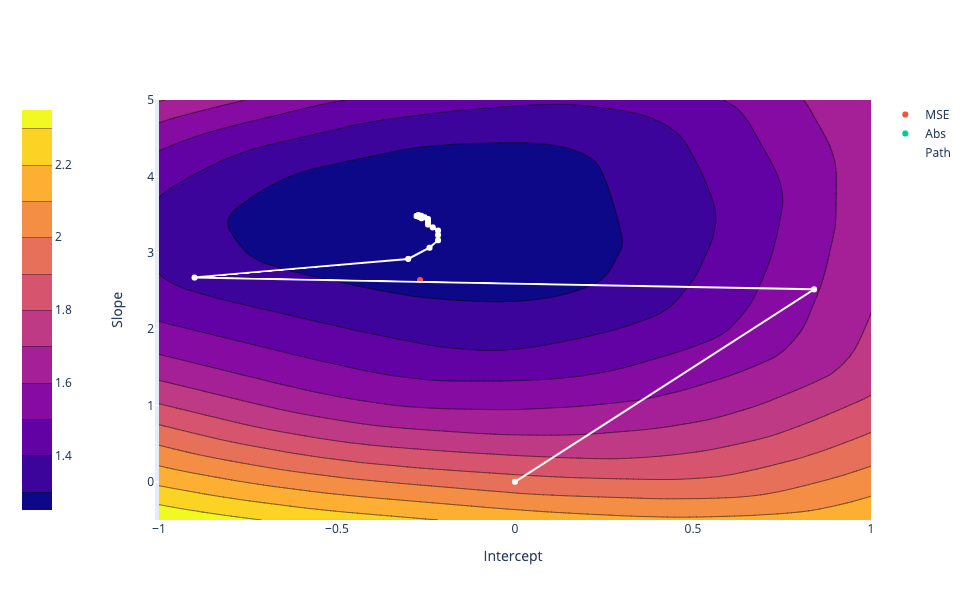

In [50]:
w0values = np.linspace(-1., 1, 50)
w1values = np.linspace(-.5, 5, 50)
(u,v) = np.meshgrid(w0values, w1values)
ws = np.vstack((u.flatten(),v.flatten())).transpose()
loss = np.array([
    F.l1_loss(ty, SimpleLinearModel(w)(tx)).item() for w in ws]).reshape(u.shape)

fig = go.Figure([go.Contour(x=w0values, y=w1values, z=loss, colorbar=dict(x=-.2)),
          go.Scatter(x=[w_mse[0]], y=[w_mse[1]], name="MSE", mode="markers"),
          go.Scatter(x=[w_abs[0]], y=[w_abs[1]], name="Abs", mode="markers"),
          go.Scatter(x=values[:,0], y=values[:,1], name="Path", mode="markers+lines", 
                     line=go.scatter.Line(color='white'))])
fig.update_layout(height=600, xaxis_title="Intercept", yaxis_title="Slope")

Visualizing the current best fit line

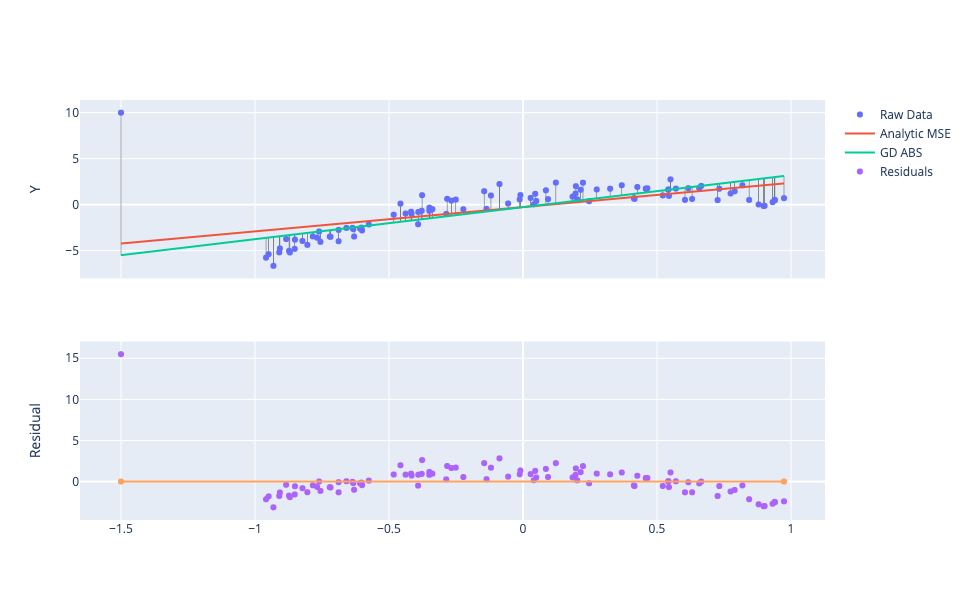

In [51]:
y_hat = lin_model(tx).detach().numpy()
gd_abs_line = go.Scatter(x=x,y=y_hat, name="GD ABS")
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
for t in residual_lines(x,y,y_hat) + [raw_data_plot, analytic_mse_line, gd_abs_line]:
    fig.add_trace(t, row=1,col=1)
fig.add_trace(go.Scatter(x=x, y = y - y_hat, mode='markers', name='Residuals'), row=2, col=1)
fig.add_trace(go.Scatter(x=[x.min(), x.max()], y = [0,0], showlegend=False), row=2, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.update_layout(height=600)

# Improving The Model

In the above we notice some curvature in the residual plot and decide to build a more complex model with an extra quadratic term.

In [52]:
class PolynomialModel(nn.Module):
    def __init__(self, w=None, p=2):
        super().__init__()
        # Creating a nn.Parameter object allows torch to track parameters for us
        if w is not None: 
            self.w = nn.Parameter(torch.from_numpy(w))
        else: 
            self.w = nn.Parameter(torch.zeros(p+1,1))
    def forward(self, x):
        w = self.w
        return torch.sum(torch.stack([w[i] * x ** i for i in range(len(w))]), dim=0)
    def numpy_parameters(self):
        """Return a numpy version of the parameters."""
        return np.array([p.detach().numpy() for p in self.parameters()]).flatten()

In [53]:
quad_model = PolynomialModel(np.array([1., 2., 3.]))
quad_model(tx)

tensor([4.7500, 1.8404, 1.8044, 1.7391, 1.6627, 1.6543, 1.5758, 1.5400, 1.5304,
        1.4734, 1.4703, 1.3860, 1.3331, 1.2766, 1.2342, 1.2149, 1.2024, 1.1176,
        1.1109, 1.0441, 1.0440, 0.9847, 0.9421, 0.9364, 0.9312, 0.8930, 0.8841,
        0.8810, 0.8423, 0.7334, 0.7128, 0.6996, 0.6879, 0.6870, 0.6768, 0.6766,
        0.6727, 0.6723, 0.6675, 0.6674, 0.6667, 0.6732, 0.6742, 0.6798, 0.6870,
        0.7034, 0.7732, 0.7834, 0.8036, 0.8474, 0.8981, 0.9756, 0.9810, 1.0594,
        1.0851, 1.0971, 1.1064, 1.1927, 1.2130, 1.2902, 1.4721, 1.5066, 1.5114,
        1.5272, 1.5690, 1.5975, 1.6756, 1.7773, 1.9671, 2.1442, 2.3409, 2.3518,
        2.3987, 2.5454, 2.5511, 2.5738, 2.8592, 2.9649, 2.9681, 2.9784, 3.0089,
        3.1166, 3.3047, 3.3749, 3.4560, 3.6118, 3.6560, 4.0345, 4.0737, 4.3481,
        4.4500, 4.6478, 4.8232, 5.0759, 5.2135, 5.2406, 5.4643, 5.5245, 5.5294,
        5.7923], dtype=torch.float64, grad_fn=<SumBackward1>)

In [54]:
quad_model = PolynomialModel()
values = gradient_descent(quad_model, F.l1_loss, tx, ty, nsteps=500, lr=10)
print("Loss =", F.l1_loss(ty, quad_model(tx)).item())
w_quad_abs = quad_model.numpy_parameters()
print("[intecept, slope, quad_term] =", w_quad_abs)

Loss = 0.7172377433786304
[intecept, slope, quad_term] = [ 1.039725   3.1892092 -3.9294097]


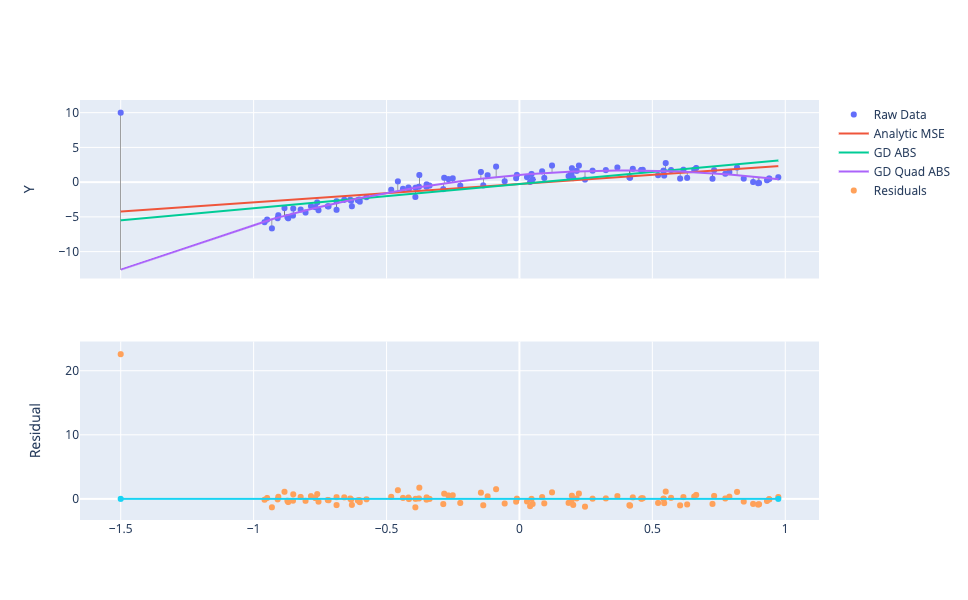

In [55]:
y_hat = quad_model(tx).detach().numpy().flatten()

gd_quad_abs_line = go.Scatter(x=x, y=y_hat, name="GD Quad ABS")
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
for t in residual_lines(x,y,y_hat) + [raw_data_plot, analytic_mse_line, gd_abs_line, gd_quad_abs_line]:
    fig.add_trace(t, row=1,col=1)
fig.add_trace(go.Scatter(x=x, y = y - y_hat , mode='markers', name='Residuals'), row=2, col=1)
fig.add_trace(go.Scatter(x=[x.min(), x.max()], y = [0,0], showlegend=False), row=2, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.update_layout(height=600)

# Implementing Stochastic Gradient Descent

First we need a mechanism to sample the data.  Since this is central to SGD (and therefore PyTorch) there is a built in way to do this:

In [56]:
from torch.utils.data import TensorDataset, DataLoader

In [57]:
dataset = TensorDataset(tx, ty)
loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [58]:
[dict(x=x, y=y) for x, y in loader]

[{'x': tensor([ 0.2751, -0.7842,  0.8437,  0.2022,  0.0285,  0.7897,  0.2466, -0.8699,
           0.0495, -0.0124,  0.8186,  0.4640,  0.3250,  0.8978,  0.7324,  0.6044,
          -0.6364, -0.9071, -0.3908, -0.8509], dtype=torch.float64),
  'y': tensor([ 1.6518, -3.4534,  0.5118,  0.5815,  0.7297,  1.4502,  0.3713, -5.2025,
           0.3951,  0.5657,  2.1030,  1.7733,  1.7344, -0.1533,  1.7261,  0.5181,
          -2.5252, -4.7626, -0.8017, -3.8080], dtype=torch.float64)},
 {'x': tensor([ 0.9738,  0.6649, -0.9588, -0.2831, -0.4381, -0.3493,  0.6575,  0.6309,
          -0.6880, -0.9312, -0.0556, -0.6590, -0.8230,  0.5216, -0.4175, -0.3496,
           0.4580,  0.5445,  0.0934,  0.9392], dtype=torch.float64),
  'y': tensor([ 0.7074,  2.0374, -5.7632,  0.6303, -0.9600, -0.3251,  1.7943,  0.6182,
          -2.7498, -6.6537,  0.1276, -2.5310, -3.9483,  1.0006, -0.7697, -0.6725,
           1.7428,  0.9475,  0.6018,  0.5282], dtype=torch.float64)},
 {'x': tensor([-0.5753,  0.4161, -0.7210, -0.3

Basic SGD implementation

In [59]:
def stochastic_gradient_descent(model, loss_fn, dataset, lr=1., nepochs=100, batch_size=10):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    values = [model.numpy_parameters()] # Track parameter values for later viz.
    for i in range(nepochs):
        for (x, y) in loader:
            loss = loss_fn(model(x), y)
            loss.backward()
            # We compute the update in a torch.no_grad context to prevent torch from 
            # trying to compute the gradient of the gradient calculation.
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr / (i + 1) * p.grad
                # We also need to clear the gradient buffer otherwise future calls will
                # accumulate the gradient. 
                model.zero_grad()
                # print(i, loss.item())
                values.append(model.numpy_parameters())
    return np.array(values)

In [60]:
quad_model_sgd = PolynomialModel(p=2)
values = stochastic_gradient_descent(quad_model_sgd, F.l1_loss, dataset, 
                                     lr=1.0, nepochs=20, batch_size=10)
print("Loss =", F.l1_loss(ty, quad_model_sgd(tx)).item())
w_quad_abs_sgd = quad_model_sgd.numpy_parameters()
print("[intecept, slope, quad_term] =", w_quad_abs_sgd)

Loss = 0.7305556363312209
[intecept, slope, quad_term] = [ 0.9064927  3.1799238 -3.5135746]


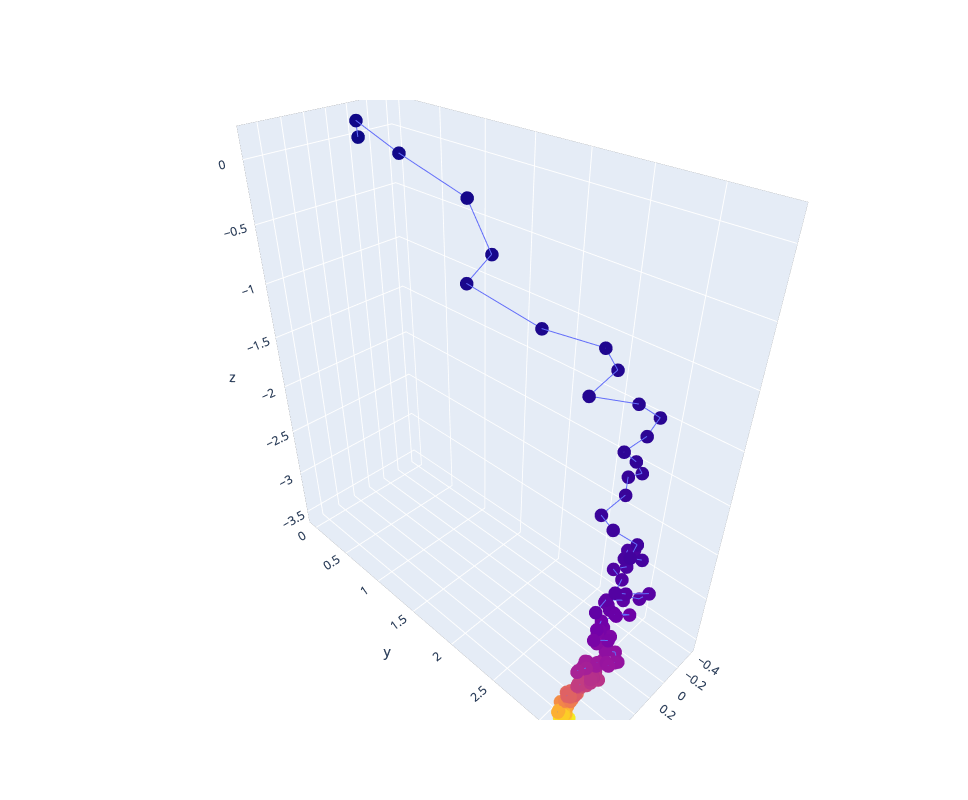

In [61]:
fig = go.Figure([go.Scatter3d(x=values[:,0], y=values[:,1], z=values[:,2], 
                              marker=dict(color=np.linspace(0,1,values.shape[0]))
                             )])
fig.update_layout(height = 800)
py.iplot(fig)

## Improving SGD with better optimizers

In [62]:
from torch.optim import Adam, SGD

In [63]:
def adam_sgd(model, loss_fn, dataset, lr=.1, nepochs=100, batch_size=10):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    opt = Adam(model.parameters(), lr=lr)
    values = [model.numpy_parameters()] # Track parameter values for later viz.
    for i in range(nepochs):
        for (x, y) in loader:
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            model.zero_grad()
            values.append(model.numpy_parameters())
    return np.array(values)

In [64]:
quad_model_sgd2 = PolynomialModel(p=2)
values = adam_sgd(quad_model_sgd2, F.l1_loss, dataset, lr = 0.1, nepochs=100, batch_size=10)
print("Loss =", F.l1_loss(ty, quad_model_sgd2(tx)).item())
w_quad_abs_sgd2 = quad_model_sgd2.numpy_parameters()
print("[intecept, slope, quad_term] =", w_quad_abs_sgd2)

Loss = 0.7377409619912195
[intecept, slope, quad_term] = [ 1.082267   2.9985147 -3.742899 ]


# More Advanced Model

In [65]:
poly_model_sgd = PolynomialModel(p=12)
values = adam_sgd(poly_model_sgd, F.l1_loss, dataset, lr=0.01, nepochs=500, batch_size=10)
print("Loss =", F.l1_loss(ty, poly_model_sgd(tx)).item())

Loss = 0.5377868130145049


Examining this Amazing Fit.

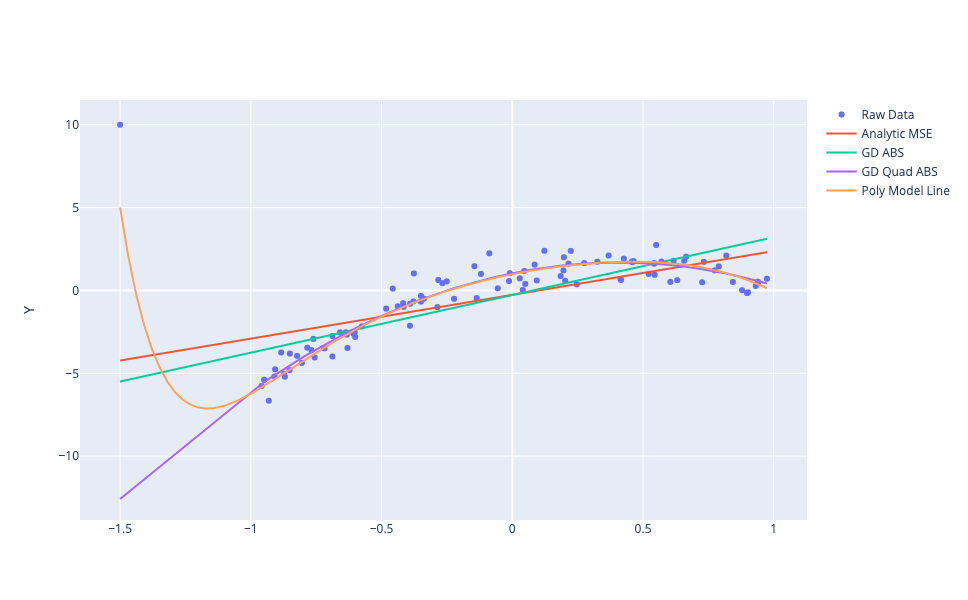

In [66]:
xtest = np.linspace(x.min(), x.max(), 1000)
y_hat = poly_model_sgd(torch.from_numpy(xtest)).detach().numpy().flatten()

poly_model_line = go.Scatter(x=xtest, y=y_hat, name="Poly Model Line")
fig = go.Figure([raw_data_plot, analytic_mse_line, gd_abs_line, gd_quad_abs_line, poly_model_line])
fig.update_yaxes(title_text="Y")
fig.update_layout(height=600)